# <font color='red'>Model building

In [1]:
import pandas as pd
import numpy as np
import os
import re
import pickle
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# For algorithms
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
with open('corpus_lemmatized.pickle', 'rb') as handle:
    df_corpus = pickle.load(handle)

In [3]:
display(df_corpus.describe())

,tag,abstract,cleaned_abstract
count,7888,7888,7888
unique,3,7888,7888
top,DMS,wan this award supports the research of profe...,davis grant cover travel expense scientist att...
freq,3666,1,1


Firstly a function is defined to identify each topic by finding its keywords:

In [4]:
def get_topic_keywords(model, feature_names, no_top_words):
    # Keep track of keywords that define topic 0 to topic n
    topic_names = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_names[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topic_names

Here a vector representing the words in the corpus is made:

In [5]:
tf_vectorizer = TfidfVectorizer(min_df=100,max_df=.8)
tf = tf_vectorizer.fit_transform(df_corpus['cleaned_abstract'].tolist())
tf_feature_names = tf_vectorizer.get_feature_names()

Now the vector is fed into the LDA model:

In [6]:
# Set number of topics
no_topics = 3
lda = LatentDirichletAllocation(n_topics=no_topics,max_iter=100, verbose=1, learning_method='online').fit(tf)

In [7]:
# Set number of keywords defining a topic
no_top_words = 10
topic_ratio = lda.transform(tf)
topics = get_topic_keywords(lda, tf_feature_names, no_top_words)

## <font color='blue'>LDA Results

Here a new data frame is created for sake of visualization:

In [8]:
visualization = df_corpus.copy()
visualization.drop('cleaned_abstract',axis=1, inplace=True)

This new column contains the ratio of all topics in one document: 

In [9]:
visualization['topics_ratio'] = np.around(topic_ratio,4).tolist()

Two new columns to keep top 5 topics and their corresponding ratios: 

In [10]:
visualization['top_topic'] = visualization['topics_ratio'].apply(lambda x: np.argsort(x)[2])
visualization['top_ratio'] = visualization['topics_ratio'].apply(lambda x: sorted(x, reverse=True)[0])
# we don't need all ratios anymore
visualization.drop('topics_ratio',axis=1, inplace=True)

In [11]:
#A summary of two above columns as a dictionary:
#final_result['top'] = final_result['topics_ratio'].apply(lambda x: dict(zip(np.argsort(x)[0:5],sorted(x, reverse=True)[0:5])))

In [12]:
visualization["topic_keywords"] = visualization["top_topic"].map(topics)
pd.set_option('display.max_colwidth', -1)
visualization.head()

,tag,abstract,top_topic,top_ratio,topic_keywords
a9000038.txt,DMS,this research is part of an on going program by the principal investigator and associates topics in the following areas are to be considered controlled markov diffusions and nonlinear pdes asymptotic properties of nearly deterministic markov processes financial economics applications singular stochastic control computational methods in stochastic control stochastic calculus of variations nonlinear estimation analytical methods based on viscosity solution techniques for nonlinear differential equations as well as probabilistic methods will be studied these theoretical studies are the basis for applied problems ranging from decisions at the stock market level to the control of spaceships,1,0.8568,"[theory, problem, equation, space, geometry, group, mathematical, analysis, investigator, method]"
a9000053.txt,DMS,the mathematical theories of multivariate polynomial interpolation and multivariate spline approximation differ in content and goals yet share a common source in addition many of the mathematical tools used to analyze basic questions are similar underlying much of this work has been the problem of developing a strategy for developing a theory of splines in several dimensions which is both computationally effective and as accurate as the one dimensional basis from which the subject arose work on multivariate polynomial interpolation derives from problems in what became known as box spline theory a surprisingly simple and general method for choosing for any given finite set of points in a space of several variables a good polynomial space for interpolation at those points has been discovered work will now be done exploring the theoretical and practical ramifications of this discovery a long term objective is to construct a coherent theory of interpolation one which will play a more important role in multivariate numerical analysis there are many approaches to spline approximation in higher dimensions currently in use each is associated with a certain type of mesh along which the elements are joined the focus of this work will be that of approximation order a better understanding of what makes for a good approximation order is expected to lead to the construction of better approximation methods ultimately one would like to develop a unification of the various theories and techniques now extant a particularly important area of application of this work is in providing mathematical models of surfaces often from a given set of bounding curves the mainstay of industrial work at this time is a method which only works for relatively flat surfaces one immediate goal is to obtain a better understanding of how one can tell whether a given surface can be well represented by a small number of patches,1,0.9160,"[theory, problem, equation, space, geometry, group, mathematical, analysis, investigator, method]"
a9000054.txt,DMS,work to be done during the period of this award will focus on higher dimensional inverse scattering problems and on related one dimensional problems the underlying idea for work of this nature is that of constructing obstacles from data measured as particles pass the obstacle the transition from the future of a solution of say the wave equation to the past is called the scattering transform knowledge of either the transform or its spectrum is considered to be central to understanding any wave or generalized wave which experiences scattering this work will consider extending results on time dependent schrodinger equations with slowly decaying potentials in which the inverse equation admits simple poles in higher dimensional settings the advent of multiple poles cannot be ruled out however their structure is not understood the question of whether or not they may accumulate will also be studied one method to be used will consider solutions for time dependent schrodinger equations which are not necessarily bounded in time this method has been used to achie

In [13]:
# with open('results_lemmatized.pickle', 'wb') as handle:
#     pickle.dump(visualization, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
topics_keywords = pd.DataFrame.from_dict(topics, orient='index')

In [15]:
topics_keywords.index = topics_keywords.index.map(str)
topics_keywords.index = 'topic ' + topics_keywords.index

In [16]:
topics_keywords

,0,1,2,3,4,5,6,7,8,9
topic 0,cell,gene,month,protein,plant,brain,development,mechanism,animal,behavior
topic 1,theory,problem,equation,space,geometry,group,mathematical,analysis,investigator,method
topic 2,chemistry,reaction,program,molecule,metal,chemical,organic,university,surface,state


## <font color='blue'>Accuracy

DMS
Counter({1: 3253, 0: 316, 2: 97})


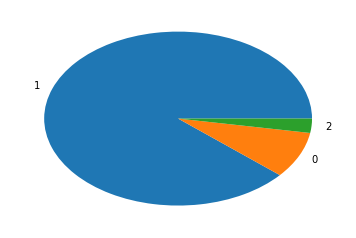

IBN
Counter({0: 1984, 2: 17, 1: 6})


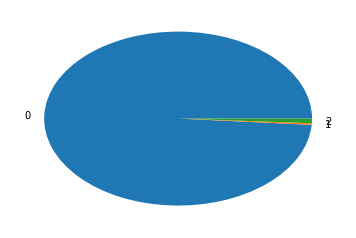

CHE
Counter({2: 2150, 0: 49, 1: 16})


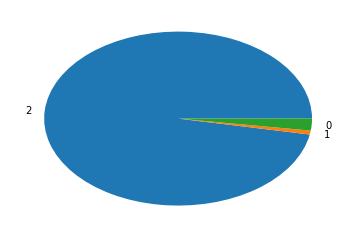

In [17]:
import matplotlib.pyplot as pyplot
from collections import Counter

for tag in visualization['tag'].unique():
    print(tag)
    topic_distribution = Counter(visualization['top_topic'][visualization['tag'] == tag].tolist())
    print(topic_distribution)
    pyplot.pie([v for v in topic_distribution.values()], labels=[k for k in topic_distribution.keys()],autopct=None)
    pyplot.show()

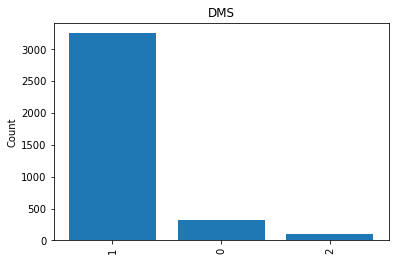

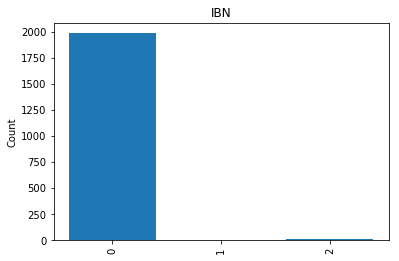

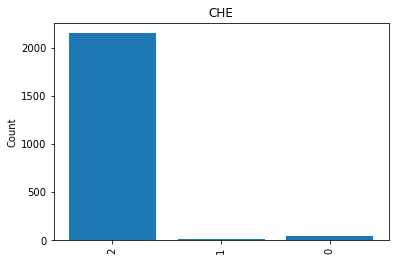

In [18]:
for tag in visualization['tag'].unique():
    topic_distribution = Counter(visualization['top_topic'][visualization['tag'] == tag].tolist())
    x = [k for k in topic_distribution.keys()]
    y = [v for v in topic_distribution.values()]
    x_pos = np.arange(len(x))

    pyplot.bar(x_pos, y, align='center')
    pyplot.xticks(x_pos, x, rotation='vertical')
    pyplot.ylabel('Count')
    pyplot.title(tag)
    pyplot.show()

In [19]:
import operator
for tag in visualization['tag'].unique():
    topic_distribution = Counter(visualization['top_topic'][visualization['tag'] == tag].tolist())
    maxTopic = max(topic_distribution.items(), key=operator.itemgetter(1))[1] # Predicted topic
    size = sum(topic_distribution.values()) # Size of documents corrospound to the tag
    print()
    print(tag, maxTopic / size)
        


DMS 0.8873431533006001

IBN 0.9885401096163428

CHE 0.9706546275395034
